#1. Linear Regression using Vectorized Implementation

This is the first assignement of the Computational Intelligence course. It includes two main parts:

- First, Linear Regression using Vectorized Implementation. 
- And the second one is to fit the best polynomial function to the data.



Let's get into the first part!

## 1.1 - Packages

Let's first import all the packages that we will need during this assignment. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [pandas](https://pandas.pydata.org/) is a library to oraganize the datasets.
- [sklearn.model_selection](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) is a function to split the dataset to train-valid-test.


In [18]:
import numpy as np
from numpy import transpose as T  
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import requests
from io import StringIO

## 1.2 - Data Exploration

CVOID-19 cases in Iran! The dataset has been downloaded from [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Iran). The data has been recorded from 19 Feb 2020 until 13 Oct 2020.

It has the four following columns:
-  Number of new cases per day.
-  Sum of new cases until then.
-  Number of deaths per day.
-  Sum of deaths until then.

Run the cell below to download it from my [Google-Drive](https://drive.google.com/file/d/1PKcsh0avHaUW2W9F3xoHHtIoYhSXbIJj/view). Then see some of the samples of dataset:


In [19]:
#download the csv file from my G-Drive
orig_url='https://drive.google.com/file/d/1vaVaANlDfj-CzbPdwvqY3TjOrDnKZyAN/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
print("Downloading the dataset...\n")
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)
print("The dataset header samples:", "\n")
print(df.head()) #see some of the first samples


The dataset header samples: 

          Date  New  New sum  Deaths  Death sum
0  19 Feb 2020    2        2       2          2
1  20 Feb 2020    3        5       0          2
2  21 Feb 2020   13       18       2          4
3  22 Feb 2020   10       28       2          6
4  23 Feb 2020   15       43       2          8


This a function for plotting data! Run the cell below please :

In [20]:
def plotData(train_x, train_y, valid_x, valid_y, test_x, test_y, model_x, model_y, title, xlabel, ylabel, drawModel=False, drawHistory=False):
  plt.figure(figsize=(700 / 96, 300 / 96), dpi=96)
  plt.style.use("seaborn")
  if not drawModel:
    plt.plot(train_x, train_y, 'ko', markersize=3)
  else:
    plt.plot(train_x, train_y, 'ko', label="train", markersize=3)
    plt.plot(valid_x, valid_y, 'go', label="valid", markersize=3)
    plt.plot(test_x, test_y, 'ro', label="test", markersize=3)
    plt.plot(model_x, model_y, 'b--', label="model", markersize=3)
    plt.legend(loc="lower right")
  if drawHistory:
    plt.plot(train_x, train_y, 'b-', label="train cost", markersize=3)
    plt.plot(valid_x, valid_y, 'r-', label="valid cost", markersize=3)
    plt.legend(loc="upper right")
  plt.title(title)
  plt.xlabel(xlabel, fontsize="10")
  plt.ylabel(ylabel, fontsize="10")
  

## 1.3 - Dataset

**Problem Statement** : In this part we will use the "Sum of the cases until each day" as the Y-axis data and the "Days" as the X-axis. We are supposed to fit a Linear Regression to this dataset.

Let's get more familiar with the dataset. Load the data by running the cell below.

Number of total examples: 45
Training set shape: (27, 1)
Validation set shape: (9, 1)
Test set shape: (9, 1)
Number of training examples: 27 



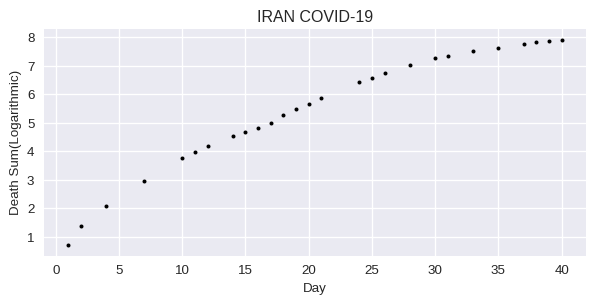

In [21]:
data = df.to_numpy()  #convert the data-frame to numpy array
n_days = 45   #number of samples(days) which we want to put in the training set. The maximum possible value for n_days is 239


x = np.array(range(len(data[:n_days])), dtype=int).reshape(n_days,1)  #days

#title = "New Sum"
#y = np.array(data[:n_days, 2], dtype=int).reshape(n_days, 1)  #new sum
#y = np.log(y)
#title = "New Cases"
#y = np.array(data[:n_days, 1], dtype=int).reshape(n_days, 1)  #new cases
#title = "Deaths"
#y = np.array(data[:n_days, 3], dtype=int).reshape(n_days, 1)  #deaths
title = "Death Sum"
y = np.array(data[:n_days, 4], dtype=int).reshape(n_days, 1)  #daeth sum

title = title + "(Logarithmic)"
y = np.log(y)

print("Number of total examples:", n_days)

random_state = None
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.40,random_state=random_state)
valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size=0.50,random_state=random_state)  # train60 valid20 test20

train = np.append(train_x, train_y, axis=1)

m = len(train_x)
print("Training set shape:", train_x.shape)
print("Validation set shape:", valid_x.shape)
print("Test set shape:", test_x.shape)
print("Number of training examples:", m, "\n")

#plotting data
plotData(train_x=train_x, train_y=train_y, valid_x=None, valid_y=None, test_x=None, test_y=None, model_x=None, model_y=None, title="IRAN COVID-19", xlabel="Day", ylabel=title, drawModel=False)


## 1.4 - Model

Our model has three main functions:
-  ComputeCost: to calculate the cost of the model.
-  gradienctDescent: to update the paramaters.
-  train: this will train our model thorugh multiple iterative epochs.


Run the cells below to define the functions please!

In [22]:
def computeCost(X, Y, w, b):
  (m, n) = X.shape  # m = number of examples, n = number of features
  pred = np.dot(X, w) + b
  loss = (pred - Y)**2  #squared loss function
  cost = np.sum(loss) / float(2*m)
  return cost

In [23]:
def gradientDescent(X, Y, w, b, lr = 1e-3):
  (m, n) = X.shape  # m = number of examples, n = number of features
  pred = np.dot(X, w) + b
  dedw = np.sum(np.multiply(pred - Y, X), axis=0).reshape(n, 1)
  dedb = np.sum(pred - Y)
  w = w - (lr / float(m)) * dedw
  b = b - (lr / float(m)) * dedb
  return w, b

In [24]:
def train(train_x, train_y, valid_x, valid_y, lr = 1e-3, epochs = 100000, polynomialDegree= 3, log=True):

  print("Fitting a polynomial function", "(Degree =", polynomialDegree, "). It may take a few seconds ...")
  (m, n) = train_x.shape  # m = number of examples, n = number of features
  w = np.zeros((n, 1))
  b = np.zeros((1, 1)) 
  
  
  for epoch in range(epochs):
    if log and epoch % (epochs / 10) == 0:
      print("\nepoch:", epoch, "/", epochs, "w =", w, "b =", b, " train cost =", computeCost(train_x, train_y, w, b), " valid cost =", computeCost(valid_x, valid_y, w, b))
    w, b = gradientDescent(train_x, train_y, w, b, lr) #to update parameters
  print("\nepoch:", epoch + 1, "/", epochs, "w =", w, "b =", b, " train cost =", computeCost(train_x, train_y, w, b), " valid cost =", computeCost(valid_x, valid_y, w, b)) 
  print("---------------------------------------------------------------------------------\n")  
   
  return w, b

## 1.5 - Train

And finally its the time for training the model :). 

Increase the number of epochs if you are looking for a better model!

In [26]:
w, b = train(train_x, train_y, valid_x, valid_y, lr=1e-3, epochs=500000, polynomialDegree= 1, log=True)

Fitting a polynomial function (Degree = 1 ). It may take a few seconds ...

epoch: 0 / 500000 w = [[0.]] b = [[0.]]  train cost = 17.132852407728  valid cost = 15.007374260407861

epoch: 50000 / 500000 w = [[0.1723322]] b = [[1.83382998]]  train cost = 0.11167979172103408  valid cost = 0.20021410516797028

epoch: 100000 / 500000 w = [[0.17233133]] b = [[1.83385368]]  train cost = 0.11167979165775807  valid cost = 0.20021591150785378

epoch: 150000 / 500000 w = [[0.17233133]] b = [[1.83385368]]  train cost = 0.11167979165775808  valid cost = 0.2002159115312736

epoch: 200000 / 500000 w = [[0.17233133]] b = [[1.83385368]]  train cost = 0.11167979165775808  valid cost = 0.2002159115312736

epoch: 250000 / 500000 w = [[0.17233133]] b = [[1.83385368]]  train cost = 0.11167979165775808  valid cost = 0.2002159115312736

epoch: 300000 / 500000 w = [[0.17233133]] b = [[1.83385368]]  train cost = 0.11167979165775808  valid cost = 0.2002159115312736

epoch: 350000 / 500000 w = [[0.17233133]] b = 

## 1.6 - Evaluate the Model


Evaluating the model...


w = [[0.17233133]] b = [[1.83385368]]  train cost = 0.11167979165775808  valid cost = 0.2002159115312736  test cost = 0.22547601839617837


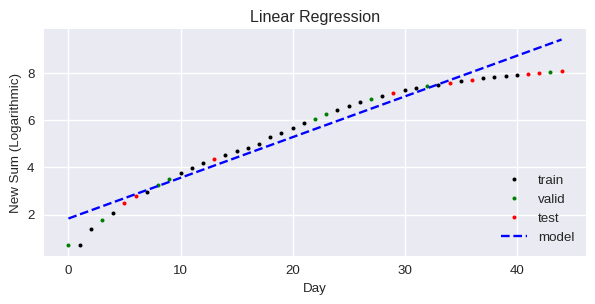

In [27]:
print("Evaluating the model...\n")
linearRegression = np.dot(x, w) + b
print("\nw =", w, "b =", b, " train cost =", computeCost(train_x, train_y, w, b), " valid cost =", computeCost(valid_x, valid_y, w, b), " test cost =", computeCost(test_x, test_y, w, b)) 
#plotting data
plotData(train_x=train_x, train_y=train_y, valid_x=valid_x, valid_y=valid_y, test_x=test_x, test_y=test_y, model_x=x, model_y=linearRegression, title="Linear Regression", xlabel="Day", ylabel="New Sum (Logarithmic)", drawModel=True)

#2. Polynomial Fitting

Now lets do some more complex! As we know, linear function is not the best function to fit the data. So here we are going to try polynomial functions as a model. Lets get into it!




## 2.1 - Data Visualization

**Problem Statement** : In this part we will use the "New cases per day" as the Y-axis data and the "Days" as the X-axis. We are supposed to fit a polynomial function to this dataset.

Let's get more familiar with the dataset. Load the data by running the cell below.

Number of total examples: 230
Training set shape: (138, 1)
Validation set shape: (46, 1)
Test set shape: (46, 1)
Number of training examples: 138 



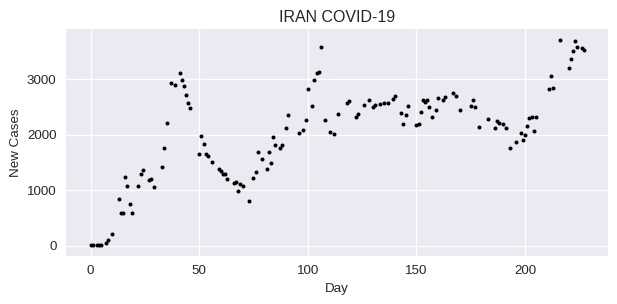

In [74]:
data = df.to_numpy()  #convert the data-frame to numpy array
n_days = 230   #number of samples(days) which we want to put in the training set. The maximum possible value for n_days is 239


x = np.array(range(len(data[:n_days])), dtype=int).reshape(n_days,1)  #days

#title = "New Sum"
#y = np.array(data[:n_days, 2], dtype=int).reshape(n_days, 1)  #new sum
#y = np.log(y)
title = "New Cases"
y = np.array(data[:n_days, 1], dtype=int).reshape(n_days, 1)  #new cases
#title = "Deaths"
#y = np.array(data[:n_days, 3], dtype=int).reshape(n_days, 1)  #deaths
#title = "Death Sum"
#y = np.array(data[:n_days, 4], dtype=int).reshape(n_days, 1)  #daeth sum

#title = title + "(Logarithmic)"
#y = np.log(y)

print("Number of total examples:", n_days)

random_state = 15
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.40, random_state= random_state)
valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size=0.50, random_state= random_state)  # train60 valid20 test20

train = np.append(train_x, train_y, axis=1)

m = len(train_x)
print("Training set shape:", train_x.shape)
print("Validation set shape:", valid_x.shape)
print("Test set shape:", test_x.shape)
print("Number of training examples:", m, "\n")

#plotting data
plotData(train_x=train_x, train_y=train_y, valid_x=None, valid_y=None, test_x=None, test_y=None, model_x=None, model_y=None, title="IRAN COVID-19", xlabel="Day", ylabel=title, drawModel=False)


## 2.2 - Feature Mapping

To increase the number of features of the trainX vector, we can use the Feature Mapping technique. It maps each individual feature to its polynomial forms.

 Then each row of the result matrix can be a vector as an example with n-dimension.

Run the cell below to observe the exact defenition of Feature Mapping.


In [75]:
%%html
<iframe src="https://drive.google.com/file/d/1bvupSawGVRZ7_tqYYHAAxiNTr5jgIRK_/preview" width="320" height="240"></iframe>

In [76]:
def mapFeature(X, degree=3):
  m = (np.size(X, axis=0))
  features = np.ones((m, degree))
  for d in range(degree):
    features[:,d] = np.power(X, d+1).reshape(m,)
  return features
  

## 2.3 - Feature Normalization

We can speed up gradient descent by having each of input values in roughly the same range. The way to prevent this is to modify the ranges of out input variavbles so taht that are all roughly the same.

Two techniques to help with this are:
- Feature Scaling
- Mean Normalization


Run the cell below to observe the Normalization formula:

In [77]:
%%html
<iframe src="https://drive.google.com/file/d/1zGgCMYslz1n2XQ8unNGFBN-RSRfDAFl6/preview" width="320" height="240"></iframe>

In [78]:
def featureNormalize(X):
  maxs = np.amax(X, axis=0) #maximum of each feature vector
  mins = np.amin(X, axis=0) #minimum of each feature vector
  means = np.mean(X, axis=0)  #mean of each feature vector
  s = maxs - mins #difference between maximum and minimim values of a feature
  normalizedFeatures = (X - mins)/ s  #feature scaling

  return normalizedFeatures


## 2.4 - Find the best Polynomial Degree

The question is "How can we find the best Polynomial Function?!"

Here is the defenition of the function which will try different polynomial functions and return the best one. As you know, the best one is the one with the lowest train and valid cost.

Run the cell below to define this function:

In [108]:
def train(train_x, train_y, valid_x, valid_y, lr = 1e-3, epochs = 100000, polynomialDegree= 3, log=True):

  print("Fitting a polynomial function", "(Degree =", polynomialDegree, "). It may take a few seconds ...")
  (m, n) = train_x.shape  # m = number of examples, n = number of features
  w = np.zeros((n, 1))
  b = np.zeros((1, 1)) 
  
  
  for epoch in range(epochs):
    if log and epoch % (epochs / 10) == 0:
      print("\nepoch:", epoch, "/", epochs, "w =", w, "b =", b, " train cost =", computeCost(train_x, train_y, w, b), " valid cost =", computeCost(valid_x, valid_y, w, b))
    w, b = gradientDescent(train_x, train_y, w, b, lr) #to update parameters
  print("\nepoch:", epoch + 1, "/", epochs, "w =", w, "b =", b, " train cost =", computeCost(train_x, train_y, w, b), " valid cost =", computeCost(valid_x, valid_y, w, b)) 
  print("---------------------------------------------------------------------------------\n")  
   
  return w, b

def train_multi_models(train_x, train_y, valid_x, valid_y, maxPolynomialDegree = 6):
  best_w = 10e+100 
  best_b = 10e+100
  best_train_cost = 10e+100
  best_valid_cost = 10e+100
  best_degree = 1

  train_costs = np.array([])
  valid_costs = np.array([])
  
  e = 10000
  for d in range(maxPolynomialDegree + 1)[1:]:
    w, b = train(train_x=train_x[:,:d], train_y=train_y, valid_x=valid_x[:, :d], valid_y=valid_y, lr=1e-1, epochs=e*(d**2),polynomialDegree=d, log=True)
    #e = e * d
    current_train_cost = computeCost(train_x[:,:d], train_y, w, b)
    current_valid_cost = computeCost(valid_x[:,:d], valid_y, w, b)

    train_costs = np.append(train_costs, [current_train_cost], axis=0)
    valid_costs = np.append(valid_costs, [current_valid_cost], axis=0)

    if (current_valid_cost < best_valid_cost):
      best_train_cost = current_train_cost
      best_valid_cost = current_valid_cost
      best_w = w
      best_b = b
      best_degree = d
    else:
      return train_costs, valid_costs, best_train_cost, best_valid_cost, best_w, best_b, best_degree
  return train_costs, valid_costs, best_train_cost, best_valid_cost, best_w, best_b, best_degree
  


Note: Since we want to create differenet polynomial functions as a model, the execution of the cell below takes a couple of minutes! 

If you want, you can decrease the parameter "maxPolynomialDegree" here:

In [113]:
maxPolynomialDegree = 10  # you can customize this parameter as the highest polynomial degree which you want check

features = mapFeature(x, degree=maxPolynomialDegree)
normalizedFeatures = featureNormalize(features)

train_x_norm, test_x_norm, train_y_norm, test_y_norm = train_test_split(normalizedFeatures, y, test_size=0.40, random_state= random_state)
valid_x_norm, test_x_norm, valid_y_norm, test_y_norm = train_test_split(test_x_norm, test_y_norm, test_size=0.50, random_state= random_state)  # train60 valid20 test20

train_costs, valid_costs, best_train_cost, best_valid_cost, best_w, best_b, best_degree = train_multi_models(train_x_norm, train_y_norm, valid_x_norm, valid_y_norm, maxPolynomialDegree = maxPolynomialDegree)


Fitting a polynomial function (Degree = 1 ). It may take a few seconds ...

epoch: 0 / 10000 w = [[0.]] b = [[0.]]  train cost = 2424193.815217391  valid cost = 2733493.3586956523

epoch: 1000 / 10000 w = [[2054.06262472]] b = [[1048.46020466]]  train cost = 185467.65567952028  valid cost = 172840.43716578055

epoch: 2000 / 10000 w = [[2055.35103668]] b = [[1047.7997794]]  train cost = 185467.58410735696  valid cost = 172840.03849725032

epoch: 3000 / 10000 w = [[2055.3524188]] b = [[1047.79907094]]  train cost = 185467.5841072746  valid cost = 172840.03814019542

epoch: 4000 / 10000 w = [[2055.35242028]] b = [[1047.79907018]]  train cost = 185467.5841072746  valid cost = 172840.03813981253

epoch: 5000 / 10000 w = [[2055.35242028]] b = [[1047.79907018]]  train cost = 185467.5841072746  valid cost = 172840.0381398121

epoch: 6000 / 10000 w = [[2055.35242028]] b = [[1047.79907018]]  train cost = 185467.5841072746  valid cost = 172840.0381398121

epoch: 7000 / 10000 w = [[2055.35242028]]

## 2.5 - Cost History Diagram

This plot will show you train/valid cost during increasing the polynomial degree for the function which your data want to be fit with.

Run the cell below to see the plot:

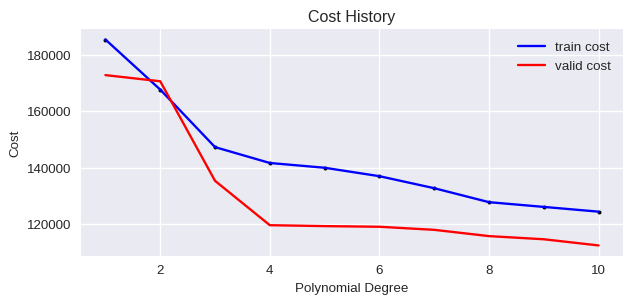

In [114]:
#plot history of costs
plotData(train_x=np.arange(1, len(train_costs) + 1, dtype=int), train_y=train_costs, valid_x=np.arange(1, len(valid_costs) + 1, dtype=int), valid_y=valid_costs, test_x=None, test_y=None, model_x=None, model_y=None, title="Cost History", xlabel="Polynomial Degree", ylabel="Cost", drawModel=False, drawHistory=True)


## 2.6 - Evaluate the Best Model

As you saw in the cost history diagram, the best polynomial function is the one which has the lowest validation cost.

This is the time to evaluate our final model via test set!

In [115]:
print("\nw =", best_w, "b =", best_b, " train cost =", computeCost(train_x_norm, train_y_norm, best_w, best_b), " valid cost =", computeCost(valid_x_norm, valid_y_norm, best_w, best_b), " test cost =", computeCost(test_x_norm, test_y_norm, best_w, best_b)) 


w = [[  9030.73514512]
 [-16788.18805625]
 [ 15541.38300313]
 [  4335.00652503]
 [-10247.89786095]
 [-12112.1930946 ]
 [ -1835.21332036]
 [ 15859.45750932]
 [    59.61969907]
 [   -75.89684745]] b = [[314.16660761]]  train cost = 124374.93255950567  valid cost = 112392.69156939191  test cost = 81478.430265203


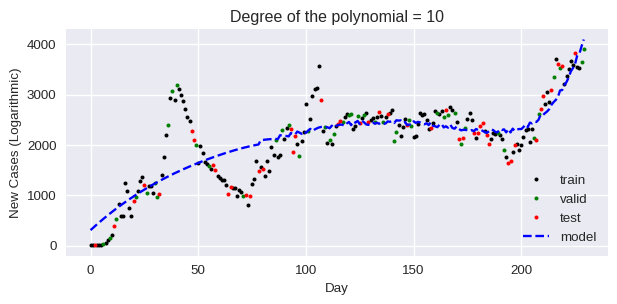

In [116]:
f = mapFeature(x, degree=best_degree)
fn = featureNormalize(f)

polynomialFunction = np.dot(fn, best_w) + best_b  # final model

#plot the model
plotData(train_x=train_x, train_y=train_y, valid_x=valid_x, valid_y=valid_y, test_x=test_x, test_y=test_y, model_x=x, model_y=polynomialFunction, title="Degree of the polynomial = " + str(best_degree), xlabel="Day", ylabel="New Cases (Logarithmic)", drawModel=True,drawHistory=False)

## 2.7 - Learn-Predict-Plot an individual Polynomial Function


This is a cell for creating your arbitrary model! Change the polynomial degree if you want.

Fitting a polynomial function (Degree = 3 ). It may take a few seconds ...

epoch: 0 / 500000 w = [[0.]
 [0.]
 [0.]] b = [[0.]]  train cost = 2418239.945652174  valid cost = 2527985.0760869565

epoch: 50000 / 500000 w = [[ 6665.38986408]
 [-8637.19489189]
 [ 4656.67716704]] b = [[443.56730792]]  train cost = 140869.97757521356  valid cost = 102025.11603555705

epoch: 100000 / 500000 w = [[  8788.24380832]
 [-13841.2696525 ]
 [  8062.32258331]] b = [[265.30662697]]  train cost = 132009.72994602664  valid cost = 96256.6718545677

epoch: 150000 / 500000 w = [[ 10013.53855836]
 [-16845.02104119]
 [ 10028.03457229]] b = [[162.41595138]]  train cost = 129057.9309871986  valid cost = 94728.47025156798

epoch: 200000 / 500000 w = [[ 10720.76913753]
 [-18578.76293001]
 [ 11162.62821059]] b = [[103.02825541]]  train cost = 128074.53667837186  valid cost = 94446.50861523226

epoch: 250000 / 500000 w = [[ 11128.97711532]
 [-19579.46523459]
 [ 11817.50681504]] b = [[68.75014019]]  train cost = 1277

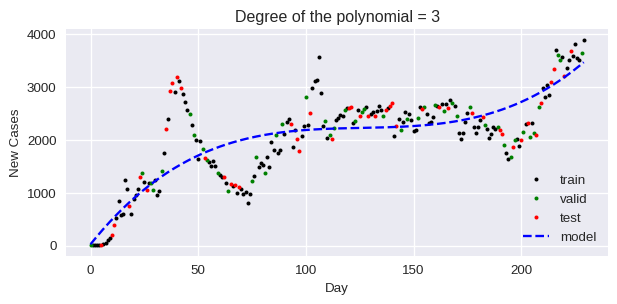

In [54]:
d = 3 #polynomial degree

features = mapFeature(x, degree=d)
normalizedFeatures = featureNormalize(features)

#normalized_y = featureNormalize(y)

train_x_norm, test_x_norm, train_y_norm, test_y_norm = train_test_split(normalizedFeatures, y, test_size=0.40, random_state= random_state)
valid_x_norm, test_x_norm, valid_y_norm, test_y_norm = train_test_split(test_x_norm, test_y_norm, test_size=0.50, random_state= random_state)  # train60 valid20 test20

w, b = train(train_x=train_x_norm[:,:d], train_y=train_y_norm, valid_x=valid_x_norm[:, :d], valid_y=valid_y_norm, lr=1e-1, epochs=500000,polynomialDegree=d, log=True)

print("\nw =", w, "b =", b, " train cost =", computeCost(train_x_norm, train_y_norm, w, b), " valid cost =", computeCost(valid_x_norm, valid_y_norm, w, b), " test cost =", computeCost(test_x_norm, test_y_norm, w, b))

polynomialFunction = np.dot(normalizedFeatures, w) + b  # final model

#plot the model
plotData(train_x=train_x, train_y=train_y, valid_x=valid_x, valid_y=valid_y, test_x=test_x, test_y=test_y, model_x=x, model_y=polynomialFunction, title="Degree of the polynomial = " + str(d), xlabel="Day", ylabel=title, drawModel=True,drawHistory=False)

## 2.8 - Things to say!

1. You may notice that sometimes the validiation and even test cost are less than the training cost. It may have the following reason:
  - Due to random seed which we choose when we want to split our dataset into train-valid-test, the samples in validation and test set are the easy ones to predict.
2. In this problem, actually the overfitting does not make sense at all! Or maybe this occures in so high degree of polynomial(around 30 or higher).